In [ ]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba
import pickle
from math import sqrt, log
from collections import defaultdict    
    
class BM25():
    def __init__(self, doc_list):
        self.doc_count = len(doc_list)
        self.avgdl = 0
        self.df = defaultdict(int)
        for doc in doc_list:
            for word in set(jieba.cut(doc)):
                self.df[word] += 1
            self.avgdl += len(doc)
        self.avgdl /= self.doc_count
    
    def score(self, q, doc):
        k1 = 1.5
        b = 0.75
        result = 0
        query_new = set(jieba.cut(q.lower())) - set(['(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', ''])
        word_list_doc = list(jieba.cut(doc.lower()))
        for keyword in query_new:
            f = word_list_doc.count(keyword)
            dl = len(doc)
            idf = log((self.doc_count - self.df[keyword] + 0.5) / (self.df[keyword] + 0.5) + 1)
            result += idf * ((f * (k1 + 1)) / (f + k1 * (1 - b + b * dl / self.avgdl)))
        return result
    

class MySearchC6V0():
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    C4V1: Add basic Bool query support
    C4V2: Add wordseg to get_word_match()
    ----------------C5V0-----------------
    C5V1: Use VSMTFIDF.score() as score
    C5V2: Use BM25.score() as score
    C5V3: Use MiddleRank -> BM25
    ----------------C6V0-----------------

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    query_to_set_expression(query):
        convert bool query to set expression(for eval process).
    get_word_match(word):
        get match set of the word.
    def mid_score(query, tid):
        get middle-rank score of doc(tid) according to query
    def cosine(vec1, vec2):
        get cosine similarity between vec1 and vec2
    def dot(vec1, vec2):
        get dot product of vec1 and vec2
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.doc_word_dict = [] #记录文档-词关系
        self.search_cache = defaultdict(set)
        self.multi_factor = multi_factor
        self.load_data(filename)
    
    def highlight(self, text, keyword, ori_text):
        idx = text.find(keyword)
        result = text
        if idx >= 0:
            ori_keyword = ori_text[idx:idx+len(keyword)]
            result = ori_text.replace(ori_keyword, f'<span style="color:red">{ori_keyword}</span>')
        return result
    
    def score(self, text, keyword):
        result = text.count(keyword)
        return result
    
    def query_to_set_expression(self, query):
        query_new_parts = []
        all_parts = list(query.replace('(', ' ( ').replace(')', ' ) ').split())
        idx = 0
        cache = ''
        count_parts = len(all_parts)
        while idx < count_parts:
            if all_parts[idx] == '(' or all_parts[idx] == ')':
                query_new_parts.append(all_parts[idx])
            elif all_parts[idx] == ' ' or all_parts[idx] == '':
                query_new_parts.append(' ')
            elif all_parts[idx] in ('and', 'AND', '+'):
                query_new_parts.append('&')
            elif all_parts[idx] in ('or', 'OR'):
                query_new_parts.append('|')
            elif all_parts[idx] in ('not', 'NOT', '-'):
                query_new_parts.append('-')
            else:
                if cache:
                    cache += ' ' + all_parts[idx]
                else:
                    cache = all_parts[idx]

                if (idx + 1 == count_parts
                  or all_parts[idx + 1] in ('(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', '')):
                    query_new_parts.append(f"self.get_word_match('{cache}')")
                    cache = ''
            idx += 1
        query_new = ''.join(query_new_parts)
        return query_new
    
    def get_word_match(self, word):
        if_first_subword = True
        result = None
        for term in list(jieba.cut(word)):
            if if_first_subword:
                result = self.search_cache[term]
                if_first_subword = False
            else:
                result = result & self.search_cache[term]
            if not result:
                break
        return result
    
    def search(self, query, num=15):
        query_lower = query.lower()    
        result_list = []
        min_score = 0
        #粗筛(候选文档)
        query_set_expression = self.query_to_set_expression(query_lower)
        match_tid_list = list(eval(query_set_expression))

        query_new = ' '.join(set(jieba.cut(query_lower)) - set(['(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', '']))
        
        #粗排(快速排序)
        mid_tid_list = [(tid, self.mid_score(query_new, tid)) for tid in match_tid_list]
        mid_tid_list.sort(key = lambda x: x[1], reverse=True)
        
        #细排序
        bm25_model = BM25([self.docs_lower[tid] for tid,_ in mid_tid_list[:num + 5]])
        result_list = [(tid, bm25_model.score(query_new, self.docs_lower[tid])) for tid,_ in mid_tid_list]
        result_list.sort(key = lambda x: x[1], reverse=True)
                           
        return [doc_id for doc_id, _ in result_list[:num]]
            
    def pre_cache_all(self):
        for tid, doc in enumerate(self.docs_lower):
            doc_tf_dict = defaultdict(int)
            doc_word_count = 0
            for word in jieba.cut_for_search(doc):
                self.search_cache[word].add(tid)
                doc_tf_dict[word] += 1
                doc_word_count += 1
            for word in doc_tf_dict:
                doc_tf_dict[word] /= doc_word_count
            self.doc_word_dict.append(doc_tf_dict)
    
    def render(self, result_list, keyword):
        count = 1
        for item in result_list:
            result = self.highlight(
                self.docs_lower[item], 
                keyword.lower(), 
                self.docs[item]
            ).replace('$$$', '<br/>') #
            display(HTML(f"{count}、{result[:150]}......")) #
            count += 1
            
    def mid_score(self, query, tid):
        vacabulary = list(set(query.split()))
        q_vec = [1] * len(vacabulary)
        d_vec = [self.doc_word_dict[tid][word] for word in vacabulary]
        score = self.cosine(q_vec, d_vec)
        return score
    
    def dot(self, vec1, vec2):
        return [vec1[i] * vec2[i] for i in range(len(vec1))]
    
    def cosine(self, vec1, vec2):
        return sum(self.dot(vec1, vec2)) / (sqrt(sum(self.dot(vec1, vec1))) * sqrt(sum(self.dot(vec2, vec2))))
    
    def load_data(self, filename):
        if filename[-3:] == 'txt':
            with open(filename, 'r') as f:
                self.docs = f.read().split('\n')
            self.docs_lower = [doc.lower() for doc in self.docs]
            self.docs = self.docs * self.multi_factor 
            self.docs_lower = self.docs_lower * self.multi_factor
            self.pre_cache_all()
        elif filename[-3:] == 'dat':
            with open(filename, 'rb') as f:
                self.docs, self.docs_lower, self.search_cache, self.doc_word_dict = pickle.load(f)
                
    def save_data(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump((self.docs, self.docs_lower, self.search_cache, self.doc_word_dict), f)
            

In [ ]:
searcher = MySearchC6V0('titles_l.txt', 1)

In [ ]:
searcher.search_cache['0-3']

In [ ]:
query = '0-3'
search_result = searcher.search(query, num=10)
searcher.render(search_result, query)

In [ ]:
' | '.join(jieba.cut_for_search('11-29'))

### 对中英/数混排文档分词粒度的思考   
### 解决方案：  
#### 对中英文/数字片段分别处理  

In [ ]:
import string

def parse_doc(doc):
    result = []
    state_last = ''
    cache = ''
    for c in doc:
        state_c = c in string.ascii_letters \
            or c.isdigit() \
            or c in ('-', ':', '.', '：', '/')
        if c == ' ':
            if state_last:
                result.append(cache)
            else:
                result.extend(list(jieba.cut_for_search(cache)))
            result.append(' ')
            cache = ''
            state_last = '' 
        else:
            if state_c == state_last:
                cache += c
            else:
                if state_last != '':
                    if state_last:
                        result.append(cache)
                    else:
                        result.extend(list(jieba.cut_for_search(cache)))
                cache = c
            state_last = state_c
    if cache:
        if state_last:
            result.append(cache)
        else:
            result.extend(list(jieba.cut_for_search(cache)))
    return result

In [ ]:
doc = '''德国杯-爆冷!拜仁0-5惨遭门兴血洗 后防灾难级表现$$$北京时间10月28日凌晨2：45，2021-2022赛季德国杯第二轮继续进行，拜仁慕尼黑客场对阵门兴格拉德巴赫，上半场，科内闪电破门，本塞拜尼连入两球，拜仁0-3落后。下半场，恩博洛梅开二度。最终，拜仁客场0-5惨败于门兴，德国杯惨遭淘汰！$$$https://www.163.com/sports/article/GNCKODUB00058781.html'''
' | '.join(parse_doc(doc))

In [ ]:
def get_char_type(c):
    """返回当前字符的类型(e,c,s,f,b)

    Args:
        c:要进行判断的单个字符

    Results:
        返回判断结果(前缀)：e为英文，c为中文，s为空格，f为引号，b为括号
    """
    result = 'c'
    if c in string.ascii_letters \
            or c.isdigit() \
            or c in ('-', ':', '.', '：', '/'):
        result = 'e'
    elif c == '"':
        result = 'f'
    elif c == ' ':
        result = 's'
    elif c in ('(', ')'):
        result = 'b'
    return result

def parse_query(doc):
    """对查询进行自定义解析，保留英文串，对中文串原型插入

    Args:
        doc:待解析的原始文档

    Returns:
        解析结果列表，元素是带有串类型标记(首字符，e为英文，c为中文，s为空格，f为引号，b为括号)
        的切分term结果
    """
    doc = doc.lower() + ' ' #解决末位字符状态切换问题的小技巧
    result = []
    doclen = len(doc)
    i = 0
    while True:
        cur_char_type = get_char_type(doc[i])
        for j in range(i+1, doclen):
            if cur_char_type == 'f': #当前符号为引号，找下一个引号
                if get_char_type(doc[j]) == 'f':
                    break
            elif get_char_type(doc[j]) != cur_char_type: #当前符号非引号，找下一个状态变化
                break
        if cur_char_type == 's': #对多个空格连续出现的情况进行合并
            result.append('s ')
        elif cur_char_type == 'f': #对引号只提取引号内字符串
            result.append(cur_char_type + doc[i+1:j])
            j += 1
        else:
            result.append(cur_char_type + doc[i:j])
        i = j
        if i >= doclen - 1:
            break
    return result

parse_query("拜仁慕尼黑0-5 AND 德国杯")

In [ ]:
def conv_part(part):
    """将带有类别标记的解析结果段 转化为 eval能进行计算的代码段

    Args:
        part:带有类别标记的解析结果段

    Results:
        eval能进行计算的代码段字符串(调用 term_match() 进行计算)
    """
    flag = part[0]
    if flag == 'e':
        return "self.get_word_match('{}')".format(part[1:])
    elif flag == 'c':
        return "(self.get_word_match('{}'))".format(
            "') & self.get_word_match('".join(jieba.cut(part[1:])))

def query_to_set_expression(query):
    query_new_parts = []
    all_parts = parse_query(query)
    idx = 0
    cache = ''
    count_parts = len(all_parts)
    while idx < count_parts:
        if all_parts[idx][1:] == '(' or all_parts[idx][1:] == ')':
            query_new_parts.append(all_parts[idx])
        elif all_parts[idx][1:] == ' ' or all_parts[idx][1:] == '':
            query_new_parts.append(' ')
        elif all_parts[idx][1:] in ('and', 'AND', '+'):
            query_new_parts.append('&')
        elif all_parts[idx][1:] in ('or', 'OR'):
            query_new_parts.append('|')
        elif all_parts[idx][1:] in ('not', 'NOT', '-'):
            query_new_parts.append('-')
        elif (idx + 1 < count_parts #对连续的内容分段结果集合中间加”&“运算符
              and all_parts[idx+1][1:] not in (' ', ')')): 
            query_new_parts.append("{} & ".format(conv_part(all_parts[idx])))
        elif (idx + 2 < count_parts #处理词间、词与符号间空格的情况
              and all_parts[idx+1][1:] == " " 
              and all_parts[idx+2][1:] not in (')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ')): 
            query_new_parts.append("{} & ".format(conv_part(all_parts[idx])))
            idx += 2
            continue
        else:
            query_new_parts.append(conv_part(cache + all_parts[idx]))
            cache = '' #合并完成清空缓存
        idx += 1
    query_new = ''.join(query_new_parts)
    return query_new

query_to_set_expression("拜仁慕尼黑0-5 AND 德国杯")

In [ ]:
del conv_part
del query_to_set_expression
del parse_doc
del get_char_type
del parse_query

In [ ]:
class MySearchC6V1(MySearchC6V0):
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    C4V1: Add basic Bool query support
    C4V2: Add wordseg to get_word_match()
    ----------------C5V0-----------------
    C5V1: Use VSMTFIDF.score() as score
    C5V2: Use BM25.score() as score
    C5V3: Use MiddleRank -> BM25
    ----------------C6V0-----------------
    C6V1: Add parse_doc to include whole Eng/Num string

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    query_to_set_expression(query):
        convert bool query to set expression(for eval process).
    get_word_match(word):
        get match set of the word.
    def mid_score(query, tid):
        get middle-rank score of doc(tid) according to query
    def cosine(vec1, vec2):
        get cosine similarity between vec1 and vec2
    def dot(vec1, vec2):
        get dot product of vec1 and vec2
    def parse_doc(doc):
        parse doc into terms, including whole Eng/Num string
    def get_char_type(c):
        get type of character c
    def parse_query(q):
        parse query q to Cn/En/Num parts with prefix
    def conv_part(part):
        convert part to set call
    """
    
    def parse_doc(self, doc):
        result = []
        state_last = ''
        cache = ''
        for c in doc:
            state_c = c in string.ascii_letters \
                or c.isdigit() \
                or c in ('-', ':', '.', '：', '/')
            if c == ' ':
                if state_last:
                    result.append(cache)
                else:
                    result.extend(list(jieba.cut_for_search(cache)))
                result.append(' ')
                cache = ''
                state_last = '' 
            else:
                if state_c == state_last:
                    cache += c
                else:
                    if state_last != '':
                        if state_last:
                            result.append(cache)
                        else:
                            result.extend(list(jieba.cut_for_search(cache)))
                    cache = c
                state_last = state_c
        if cache:
            if state_last:
                result.append(cache)
            else:
                result.extend(list(jieba.cut_for_search(cache)))
        return result
    
    def pre_cache_all(self):
        for tid, doc in enumerate(self.docs_lower):
            doc_tf_dict = defaultdict(int)
            doc_word_count = 0
            for word in self.parse_doc(doc):
                self.search_cache[word].add(tid)
                doc_tf_dict[word] += 1
                doc_word_count += 1
            for word in doc_tf_dict:
                doc_tf_dict[word] /= doc_word_count
            self.doc_word_dict.append(doc_tf_dict)
            
    def get_char_type(self, c):
        """返回当前字符的类型(e,c,s,f,b)

        Args:
            c:要进行判断的单个字符

        Results:
            返回判断结果(前缀)：e为英文，c为中文，s为空格，f为引号，b为括号
        """
        result = 'c'
        if c in string.ascii_letters \
                or c.isdigit() \
                or c in ('-', ':', '.', '：', '/'):
            result = 'e'
        elif c == '"':
            result = 'f'
        elif c == ' ':
            result = 's'
        elif c in ('(', ')'):
            result = 'b'
        return result

    def parse_query(self, doc):
        """对查询进行自定义解析，保留英文串，对中文串原型插入

        Args:
            doc:待解析的原始文档

        Returns:
            解析结果列表，元素是带有串类型标记(首字符，e为英文，c为中文，s为空格，f为引号，b为括号)
            的切分term结果
        """
        doc = doc.lower() + ' ' #解决末位字符状态切换问题的小技巧
        result = []
        doclen = len(doc)
        i = 0
        while True:
            cur_char_type = self.get_char_type(doc[i])
            for j in range(i+1, doclen):
                if cur_char_type == 'f': #当前符号为引号，找下一个引号
                    if self.get_char_type(doc[j]) == 'f':
                        break
                elif self.get_char_type(doc[j]) != cur_char_type: #当前符号非引号，找下一个状态变化
                    break
            if cur_char_type == 's': #对多个空格连续出现的情况进行合并
                result.append('s ')
            elif cur_char_type == 'f': #对引号只提取引号内字符串
                result.append(cur_char_type + doc[i+1:j])
                j += 1
            else:
                result.append(cur_char_type + doc[i:j])
            i = j
            if i >= doclen - 1:
                break
        return result
    
    def conv_part(self, part):
        """将带有类别标记的解析结果段 转化为 eval能进行计算的代码段

        Args:
            part:带有类别标记的解析结果段

        Results:
            eval能进行计算的代码段字符串(调用 term_match() 进行计算)
        """
        flag = part[0]
        if flag == 'e':
            return "self.get_term_match('{}')".format(part[1:])
        elif flag == 'c':
            return "(self.get_term_match('{}'))".format(
                "') & self.get_term_match('".join(jieba.cut(part[1:])))

    def query_to_set_expression(self, query):
        query_new_parts = []
        all_parts = self.parse_query(query)
        idx = 0
        cache = ''
        count_parts = len(all_parts)
        while idx < count_parts:
            if all_parts[idx][1:] == '(' or all_parts[idx][1:] == ')':
                query_new_parts.append(all_parts[idx])
            elif all_parts[idx][1:] == ' ' or all_parts[idx][1:] == '':
                query_new_parts.append(' ')
            elif all_parts[idx][1:] in ('and', 'AND', '+'):
                query_new_parts.append('&')
            elif all_parts[idx][1:] in ('or', 'OR'):
                query_new_parts.append('|')
            elif all_parts[idx][1:] in ('not', 'NOT', '-'):
                query_new_parts.append('-')
            elif (idx + 1 < count_parts #对连续的内容分段结果集合中间加”&“运算符
                  and all_parts[idx+1][1:] not in (' ', ')')): 
                query_new_parts.append("{} & ".format(self.conv_part(all_parts[idx])))
            elif (idx + 2 < count_parts #处理词间、词与符号间空格的情况
                  and all_parts[idx+1][1:] == " " 
                  and all_parts[idx+2][1:] not in (')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ')): 
                query_new_parts.append("{} & ".format(self.conv_part(all_parts[idx])))
                idx += 2
                continue
            else:
                query_new_parts.append(self.conv_part(cache + all_parts[idx]))
                cache = '' #合并完成清空缓存
            idx += 1
        query_new = ''.join(query_new_parts)
        return query_new
    
    def get_term_match(self, term):
        return self.search_cache.get(term, set()) 

In [ ]:
searcher = MySearchC6V1('titles_l.txt', 1)

In [ ]:
query = '拜仁0-5 AND 德国杯'
search_result = searcher.search(query, num=10)
searcher.render(search_result, query)

In [ ]:
searcher.query_to_set_expression(query)

In [ ]:
query = 'to be or not to be'
search_result = searcher.search(query, num=10)
searcher.render(search_result, query)

### 对特殊短语的查询需求，比如“0-3”，“to be or not to be” —— 临近查询 
#### - 采用特殊索引结构

In [ ]:
class MySearchC6V2(MySearchC6V1):
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    C4V1: Add basic Bool query support
    C4V2: Add wordseg to get_word_match()
    ----------------C5V0-----------------
    C5V1: Use VSMTFIDF.score() as score
    C5V2: Use BM25.score() as score
    C5V3: Use MiddleRank -> BM25
    ----------------C6V0-----------------
    C6V1: Add parse_doc to include whole Eng/Num string
    C6V2: Add 2gram-Inverted-Index and get_frag_match()

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    query_to_set_expression(query):
        convert bool query to set expression(for eval process).
    get_word_match(word):
        get match set of the word.
    def mid_score(query, tid):
        get middle-rank score of doc(tid) according to query
    def cosine(vec1, vec2):
        get cosine similarity between vec1 and vec2
    def dot(vec1, vec2):
        get dot product of vec1 and vec2
    def parse_doc(doc):
        parse doc into terms, including whole Eng/Num string
    def get_char_type(c):
        get type of character c
    def parse_query(q):
        parse query q to Cn/En/Num parts with prefix
    def conv_part(part):
        convert part to set call
    def get_frag_match(frag):
        get docs matching frag
    def get_term_match(term):
        get docs macthing term
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.doc_word_dict = [] #记录文档-词关系
        self.search_cache = defaultdict(set)
        self.search_cache_b = defaultdict(set) #2gram索引
        self.multi_factor = multi_factor
        self.load_data(filename)
    
    def pre_cache_all(self):
        for tid, doc in enumerate(self.docs_lower):
            doc_tf_dict = defaultdict(int)
            doc_word_count = 0
            for word in self.parse_doc(doc):
                self.search_cache[word].add(tid)
                doc_tf_dict[word] += 1
                doc_word_count += 1
            for word in doc_tf_dict:
                doc_tf_dict[word] /= doc_word_count
            self.doc_word_dict.append(doc_tf_dict)
            
            doclen = len(doc)
            for i in range(doclen-1):
                term = doc[i:i+2]
                self.search_cache_b[term].add(tid)

    def get_frag_match(self, frag):
        """对片段frag用ngram索引实现原样搜索
        
        Args:
            frag:要原样搜索的字符串
            
        Results:
            片段原样搜索的结果(文档ID)集合
        """
        frag = frag.lower() #大小写归一化
        result = None
        doclen = len(frag)
        for i in range(doclen - 1):
            term = frag[i:i+2]
            if result is None:
                result = self.search_cache_b.get(term, set())
            else:
                result = result & self.search_cache_b.get(term, set())
        return result

In [ ]:
searcher = MySearchC6V2('titles_l.txt', 1)

In [ ]:
searcher.get_frag_match('to be or not to be')

### 用2-gram轮换索引实现拼写校正
#### 针对最常见的拼写错误类型：缺字母、多字母、错字母
#### 例如：receive -> receve &nbsp;&nbsp; precision -> presision  

用nltk获取英文词表：

In [ ]:
import nltk
print(nltk.corpus.words.words()[:10])

In [262]:
from collections import Counter, defaultdict
import nltk

class Corrector():
    """用二元索引实现拼写校正
    
    Attributes:
        index_b: 检索使用的二元索引
        max_id: 当前索引的单词最大ID
        doc_list: 索引单词原文
    """
    def __init__(self): 
        """初始化，用NLTK的words词典构建倒排索引
        """
        self.index_b = defaultdict(list) #ngram索引
        self.max_id = 0
        self.doc_list = [] 
        
        for doc in nltk.corpus.words.words():
            self.add_doc(doc)
            
    def add_doc(self, doc):
        """向索引中添加新词(单词的二元索引)
        
        Args:
            doc:待检索的单词
        
        Returns:
            新增单词ID
        """
        self.doc_list.append(doc)
        doc = doc.lower()
        
        #构建二元索引
        doclen = len(doc)
        for i in range(doclen-1):
            term = doc[i:i+2]
            self.index_b[term].append(self.max_id)
                
        self.max_id += 1
        return self.max_id - 1
    
    def correct(self, word, limit=5):
        """拼写校正函数
        
        Args:
            word:待校正的词
            limit:返回结果的最大条数，默认值为5
            
        Returns:
            最可能的校正单词列表
        """
        word = word.lower() #大小写归一化
        result = []
        docid_list = []
        doclen = len(word)
        for i in range(doclen - 1):
            term = word[i:i+2]
            docid_list += self.index_b.get(term, [])
        docid_counter = Counter(docid_list)
        count = 0
        for elem in docid_counter.most_common(300):
            cor_word = self.doc_list[elem[0]]
            if len(cor_word) >= doclen - 1 and len(cor_word) <= doclen + 1:
                result.append((cor_word, elem[1]))
                count += 1
                if count > limit:
                    break
        return result

In [263]:
cor = Corrector()

In [264]:
print(cor.correct('retrival'))

[('retrieval', 6), ('pretribal', 5), ('rearrival', 5), ('rerival', 5), ('retreatal', 5), ('retrial', 5)]


In [265]:
print(cor.correct('presision'))

[('presession', 8), ('repression', 8), ('depression', 7), ('expression', 7), ('impression', 7), ('misprision', 7)]


In [266]:
from collections import Counter, defaultdict
import nltk

class Corrector():
    """用三元索引实现拼写校正
    
    Attributes:
        index_t: 检索使用的三元索引
        max_id: 当前索引的单词最大ID
        doc_list: 索引单词原文
    """
    def __init__(self): 
        """初始化，用NLTK的words词典构建倒排索引
        """
        self.index_t = defaultdict(list) #ngram索引
        self.max_id = 0
        self.doc_list = [] 
        
        for doc in nltk.corpus.words.words():
            self.add_doc(doc)
            
    def add_doc(self, doc):
        """向索引中添加新词(单词的二元索引)
        
        Args:
            doc:待检索的单词
        
        Returns:
            新增单词ID
        """
        self.doc_list.append(doc)
        doc = doc.lower()
        
        #构建二元索引
        doclen = len(doc)
        for i in range(doclen-2):
            term = doc[i:i+3]
            self.index_t[term].append(self.max_id)
                
        self.max_id += 1
        return self.max_id - 1
    
    def correct(self, word, limit=5):
        """拼写校正函数
        
        Args:
            word:待校正的词
            limit:返回结果的最大条数，默认值为5
            
        Returns:
            最可能的校正单词列表
        """
        word = word.lower() #大小写归一化
        result = []
        docid_list = []
        doclen = len(word)
        for i in range(doclen - 2):
            term = word[i:i+3]
            docid_list += self.index_t.get(term, [])
        docid_counter = Counter(docid_list)
        count = 0
        for elem in docid_counter.most_common(300):
            cor_word = self.doc_list[elem[0]]
            if len(cor_word) >= doclen - 1 and len(cor_word) <= doclen + 1:
                result.append((cor_word, elem[1]))
                count += 1
                if count > limit:
                    break
        return result

In [267]:
cor = Corrector()

In [268]:
print(cor.correct('retrival'))

[('retrieval', 4), ('outrival', 4), ('trivalent', 4), ('trivalve', 4), ('Eretrian', 3), ('heretrix', 3)]


In [269]:
print(cor.correct('presision'))

[('depression', 4), ('expression', 4), ('impression', 4), ('oppression', 4), ('precision', 4), ('presension', 4)]


### 用2-gram保留词序信息在文档去重上的应用  
#### KShingle方法：
K-shingle算法通过将文档表示为K-shingle的集合，比较各文档K-shingle集合之间的相似性，来衡 量文档的相似度。算法主要步骤如下:
1. 预处理：读取文档数据集，根据需求，对文档中的标点、空白、中英文、简繁体等字符进行清洗 和整理。
2. 提取K-shingle：对清洗后的文档进行分词处理, 指定shingle长度 $K$, 对每篇文档提取对应的 K-shingle集合。
3. 统计特征向量：所有文档的K-shingle互异值构成一个大小为 $M$ 的词组库。用one-hot的方式对 每篇文档进行编码, 得到一个长度为 $M$ 的特征向量, 当词组库中的第 $m$ 个K-shingle在文档中 出现时，该文档特征向量的第 $m$ 个元素为1, 否则为0。
4. 计算Jaccard相似度：对于集合 $A$ 和集合 $B$, Jaccard相似度定义为交集元素占并集元素的比 例大小, 即 $\frac{|A \cap B|}{|A \cup B|}$, 显然比例越大，集合越相似。对两篇文档的特征向量而言，分子指同位元 素都为1的元素个数，分母指同位元素至少一个为1的元素个数。
5. 文本去重：基于文档相似度的结果，根据预定规则，舍弃重复文本。

In [270]:
doc_0 = """目前，广州市正在3~11岁人群中持续推进新冠疫苗接种工作，广州该年龄段儿童的接种量已超过30万剂。在当前的疫情防控形势下，孩子究竟有没有必要接种新冠疫苗？儿童接种剂量与成人一样吗？昨日，就家长所关心的接种必要性、有效性和安全性等问题，疾控专家进行了解答。

　　文/广州日报全媒体记者伍仞 通讯员穗卫健宣、穗疾控

　　接种后能有效预防感染、重症和死亡发生

　　是否有必要给孩子接种新冠疫苗呢？广州市疾病预防控制中心免疫规划部副部长张春焕副主任医师表示，基于以下原因，3~11岁儿童接种新冠疫苗和其他人群一样，是非常有必要的。

　　首先是从个体预防感染的角度和降低重症率、死亡率方面的作用来看，疫苗是有效的。尽管在新冠肺炎疫情早期儿童感染的情况较少，但随着全球疫情的持续进行，目前在一些国家发现儿童感染病例数有上升趋势，甚至接近当地去年成人发病的水平。目前来看，儿童感染新冠病毒后，重症率和死亡率较低，但在一些疫情严重的国家已经出现了儿童重症和死亡病例，有些国家报道的儿童感染新冠病毒后出现重症和死亡的数据，甚至已超过了流感流行时的水平。另外，从我国疫情防控管理的角度来说，假如儿童感染病毒，和成人一样也需要进行隔离管理。

　　他介绍，对新冠疫苗在3~11岁儿童中使用，疫苗生产企业和国家有关部门做过临床试验，从前期数据来看，是可以有效预防感染、重症和死亡的发生的。

　　第二，从在人群中建立免疫屏障的角度看，3~11岁儿童也是人群的一部分，通过开展接种，让此前是免疫空白的这部分人群中免疫水平也提高，有利于尽快建立全人群免疫屏障，同样是非常有必要的。

　　儿童接种不良反应情况与成人无显著差异

　　张春焕介绍，目前我国批准在3~11岁人群中使用的新冠疫苗，为北京生物、科兴中维、武汉生物所生产以及委托其他公司进行分包装的灭活疫苗，此前已在12岁以上人群中大规模使用。“从前期的数据来看，3~11岁人群接种新冠病毒灭活疫苗，不良反应的情况跟在成人里面使用没有显著性差异。”他说。

　　记者从市疾病预防控制中心了解到，截至11月2日，广州市3~11岁人群中已有30万人接种首剂新冠疫苗，从目前观察来看，没有出现严重不良反应报告。

　　有家长关注到，3~11岁人群所使用的新冠病毒灭活疫苗剂量与12岁以上人群相同。张春焕表示，这一剂量对该年龄段孩子的安全性和有效性同样得到了临床试验的证实，家长对此不需要担心，实际上如常用的流感疫苗等，3岁以上儿童和成人也是接种同样的剂量。

　　值得注意的是，新冠疫苗和其他疫苗的接种时间需要间隔14天以上。根据相关指引，当儿童到了接种某种免疫规划疫苗的规定时间段，应该优先接种免疫规划疫苗，隔14天以后再接种新冠疫苗。"""

doc_1 = """3-11岁儿童为什么需要接种新冠病毒疫苗？

　　根据国家统一部署，陕西省已从11月1日起启动3-11岁人群新冠病毒疫苗接种工作，力争尽早建立人群免疫屏障，持续巩固疫情防控成果。针对群众关心的问题，省卫健委组织省疾控中心专家梳理和解答如下：

　　1.3-11岁儿童为什么需要接种新冠病毒疫苗？

　　接种新冠病毒疫苗是建立人群免疫屏障，控制新冠肺炎疫情传播的重要措施。儿童、青少年和18岁以上人群一样，都是免疫屏障构筑的重点人群。学校属于人口密集场所，一旦有新冠肺炎疫情发生，易造成局部的传播流行。通过接种疫苗，为3-11岁人群提供更好的防护，一方面使得绝大部分人可以获得免疫力，从而有效降低发病、重症和死亡的风险；另一方面通过有序接种新冠病毒疫苗，可在3-11岁儿童中逐步建立起免疫屏障，阻断新冠肺炎的流行，保障在校学生学习生活正常运转。

　　2.3-11岁人群接种的新冠病毒疫苗有哪些？

　　3-11岁人群接种需使用国药中生北京公司（含兰州生物制品研究所有限责任公司、成都生物制品研究所有限责任公司、长春生物制品研究所有限责任公司、长春祈健生物制品有限公司）、国药中生武汉公司和北京科兴公司生产的灭活疫苗。

　　3.3-11岁人群接种的新冠病毒疫苗，安全吗？

　　新冠病毒灭活疫苗在3-11岁人群中的安全性和免疫原性与18岁以上的人群没有显著性差异，一样安全。

　　4.3-11岁人群什么情况下不能接种新冠病毒疫苗?

　　3-11岁人群接种新冠病毒疫苗的禁忌症和基础免疫基本相同，主要包括：

　　（1）对疫苗的活性成分、任何一种非活性成分、生产工艺中使用的物质过敏者，或以前接种同类疫苗时出现过敏者；

　　（2）既往发生过疫苗严重过敏反应者（如急性过敏反应、血管神经性水肿、呼吸困难等）；

　　（3）患有未控制的癫痫和其他严重神经系统疾病者（如横贯性脊髓炎、格林巴利综合症、脱髓鞘疾病等）；

　　（4）正在发热者，或患急性疾病，或慢性疾病的急性发作期，或未控制的严重慢性病患者。

　　5.3-11岁人群到哪接种？

　　3-11岁人群在监护人陪同下自行前往就近开放的新冠病毒疫苗接种点接种，也可以由属地安排学生专场接种。具体接种安排，以各市、县（区）的最新公告为准。

　　6.3-11岁人群接种免费吗？

　　3-11岁人群接种新冠病毒疫苗实施免费接种，个人不承担接种费用。

　　7.3-11岁人群接种有哪些注意事项？

　　鉴于3-11岁年龄段属于未成年人，没有完全民事行为能力的特殊性，该年龄段人群接种新冠病毒疫苗需要监护人陪同，其中3-8岁儿童需由监护人签订疫苗接种知情同意书，8岁以上需儿童和家长同时签订知情同意书。

　　接种准备：儿童监护人需要了解新冠肺炎疾病和新冠病毒疫苗接种相关知识，为儿童带好接种证、身份证（或户口簿）；接种前避免孩子空腹、劳累，提醒孩子当天穿宽松的衣服方便接种。

　　在接种现场时，监护人要将孩子的健康状况、心理紧张情况、接种疫苗的禁忌及疾病史等如实告知接种医生。

　　接种时，监护人要全程陪护，并注意保持一米的距离，全程佩戴口罩。

　　接种后，在现场留观30分钟，如出现不适，请及时联系现场工作人员。

　　接种当天，保持接种局部皮肤清洁，避免用手搔抓接种部位；如发生疑似不良反应，报告接种单位，需要时及时就医。

　　需要提醒的是，如果近期接种过其他疫苗，要间隔14天后再接种新冠病毒疫苗。接种新冠病毒疫苗后，建议与接种其他疫苗至少间隔14天以上。3-6岁人群新冠病毒疫苗接种时间与国家常规免疫规划疫苗接种发生冲突时，优先完成国家常规免疫规划疫苗接种。接种新冠疫苗后48小时内不要去有关机构检测核酸。

　　接种新冠病毒疫苗是预防新冠肺炎最有效的措施，为了您孩子的健康，请尽快陪同和监护子女完成新冠病毒疫苗接种！"""

doc_3 = """广州持续推进3~11岁人群新冠疫苗接种工作 疾控专家解答家长关注问题
　　广州儿童新冠疫苗接种量超30万剂

　　目前，广州市正在3~11岁人群中持续推进新冠疫苗接种工作，广州该年龄段儿童的接种量已超过30万剂。在当前的疫情防控形势下，孩子究竟有没有必要接种新冠疫苗？儿童接种剂量与成人一样吗？昨日，就家长所关心的接种必要性、有效性和安全性等问题，疾控专家进行了解答。

　　文/广州日报全媒体记者伍仞 通讯员穗卫健宣、穗疾控

　　接种后能有效预防感染、重症和死亡发生

　　是否有必要给孩子接种新冠疫苗呢？广州市疾病预防控制中心免疫规划部副部长张春焕副主任医师表示，基于以下原因，3~11岁儿童接种新冠疫苗和其他人群一样，是非常有必要的。

　　首先是从个体预防感染的角度和降低重症率、死亡率方面的作用来看，疫苗是有效的。尽管在新冠肺炎疫情早期儿童感染的情况较少，但随着全球疫情的持续进行，目前在一些国家发现儿童感染病例数有上升趋势，甚至接近当地去年成人发病的水平。目前来看，儿童感染新冠病毒后，重症率和死亡率较低，但在一些疫情严重的国家已经出现了儿童重症和死亡病例，有些国家报道的儿童感染新冠病毒后出现重症和死亡的数据，甚至已超过了流感流行时的水平。另外，从我国疫情防控管理的角度来说，假如儿童感染病毒，和成人一样也需要进行隔离管理。

　　他介绍，对新冠疫苗在3~11岁儿童中使用，疫苗生产企业和国家有关部门做过临床试验，从前期数据来看，是可以有效预防感染、重症和死亡的发生的。

　　第二，从在人群中建立免疫屏障的角度看，3~11岁儿童也是人群的一部分，通过开展接种，让此前是免疫空白的这部分人群中免疫水平也提高，有利于尽快建立全人群免疫屏障，同样是非常有必要的。

　　儿童接种不良反应情况与成人无显著差异

　　张春焕介绍，目前我国批准在3~11岁人群中使用的新冠疫苗，为北京生物、科兴中维、武汉生物所生产以及委托其他公司进行分包装的灭活疫苗，此前已在12岁以上人群中大规模使用。“从前期的数据来看，3~11岁人群接种新冠病毒灭活疫苗，不良反应的情况跟在成人里面使用没有显著性差异。”他说。

　　记者从市疾病预防控制中心了解到，截至11月2日，广州市3~11岁人群中已有30万人接种首剂新冠疫苗，从目前观察来看，没有出现严重不良反应报告。

　　有家长关注到，3~11岁人群所使用的新冠病毒灭活疫苗剂量与12岁以上人群相同。张春焕表示，这一剂量对该年龄段孩子的安全性和有效性同样得到了临床试验的证实，家长对此不需要担心，实际上如常用的流感疫苗等，3岁以上儿童和成人也是接种同样的剂量。

　　值得注意的是，新冠疫苗和其他疫苗的接种时间需要间隔14天以上。根据相关指引，当儿童到了接种某种免疫规划疫苗的规定时间段，应该优先接种免疫规划疫苗，隔14天以后再接种新冠疫苗。"""

In [271]:
import jieba

def doc_to_2gram_shingles(doc):
    shingles = set([])
    doc_segs = list(jieba.cut(doc))
    for i in range(len(doc_segs) - 1):
        shingles.add(tuple(doc_segs[i:i+2]))
    return shingles

def k_shingle_2gram(doc1, doc2):
    shingles_1 = doc_to_2gram_shingles(doc1)
    shingles_2 = doc_to_2gram_shingles(doc2)
    return len(shingles_1 & shingles_2) / len(shingles_1 | shingles_2)

In [ ]:
doc_to_2gram_shingles(doc_0)

In [273]:
k_shingle_2gram(doc_0, doc_1)

0.06545454545454546

In [274]:
k_shingle_2gram(doc_0, doc_3)

0.9697542533081286

In [275]:
def doc_to_3gram_shingles(doc):
    shingles = set([])
    doc_segs = list(jieba.cut(doc))
    for i in range(len(doc_segs) - 2):
        shingles.add(tuple(doc_segs[i:i+3]))
    return shingles

def k_shingle_3gram(doc1, doc2):
    shingles_1 = doc_to_3gram_shingles(doc1)
    shingles_2 = doc_to_3gram_shingles(doc2)
    return len(shingles_1 & shingles_2) / len(shingles_1 | shingles_2)

In [276]:
k_shingle_3gram(doc_0, doc_1)

0.027210884353741496

In [277]:
k_shingle_3gram(doc_0, doc_3)

0.9585987261146497

在整个文档集中找最相似文档：

In [278]:
with open('titles_l.txt') as f:
    doc_list = f.read().split('\n')

In [279]:
doc_list[0]

'3699元新机登场！极端环境下工作无压力 苹果索尼却挂了$$$今天下午，官方介绍，AGM G1系列是AGM打造的能在超极端环境下使用的手机。它是一个激进的系列，它存在着一些极少数人才需求的功能。而这些少数派，就是AGM的用户。也正因为做这件事很难，难度不亚于登月，非常吃力不讨好；所以我们把这场发布会叫做“登月计划”。据悉，官方介绍，AGM G1采用宽工作温度电池，内部代号“北极芯”。“北极芯”是AGM特别定制研发，能有效抗低温。通过特制的溶剂在低温环境之下提高电池的活性，让电池在零下30度能正常供电。同时热循环系统使CPU的热量均匀分布机身四周，为电池提供热保护。不仅如此，规格方面，AGM G1采用6.53英寸屏幕，搭载高通骁龙480处理器，配备8GB内存、256GB存储，后置4800万AI三摄，电池为6200mAh。AGM G1 Pro采用6.53英寸屏幕，搭载奥通骁龙480处理器，配备8GB内存、256GB存储，后置4800万AI四摄，电池容量为6200mAh。 - THE END -转载请注明出处：快科技     $$$https://news.mydrivers.com/1/792/792183.htm'

In [281]:
doc_id = 4
doc_sim_list = []
for idx, doc in enumerate(doc_list[:200]):
    if idx != doc_id:
        doc_sim_list.append((idx, k_shingle_2gram(doc_list[doc_id], doc_list[idx])))
doc_sim_list.sort(key=lambda x: x[1], reverse=True)
print(doc_list[doc_id][:100])
print('---------------')
for i in range(5):
    print(f"{i+1}.[{doc_sim_list[i][1]:.3f}]{doc_list[doc_sim_list[i][0]][:100]}")

炒股巨亏15亿 千亿白马股价大跌！官方回应来了$$$10月28日，话题云南白药炒股亏了15亿登上热搜榜。10月27日，云南白药发布三季报。公司前三季度实现营收283.63亿元，同比增长18.52%；实
---------------
1.[0.366]云南白药不务正业：买小米股票亏了6个亿！$$$云南白药和片仔癀作为同样拥有古老传承配方的上市企业，前者在话题度上远远不如片仔癀，市值也出现了几倍的差距，但是两者的差距还不止这些。10月27日，云南白药
2.[0.124]二房东跑路 彻底坑惨阿里腾讯等互联网员工！官方致歉$$$据媒体报道，近日，有一则反映“北京望京某二房东跑路，受害者多为大厂程序员”的网帖在网络流传。网帖反映，“这位二房东通过从自如/中介手中租来房屋，
3.[0.122]同花顺崩了上热搜 系统崩溃 股民亏哭：官方回应$$$就早盘出现App崩溃一事，刚刚，同花顺通过官方微博回应称：据多位微博网友反馈，同花顺App早盘出现大面积登录故障，具体情况为：无法登录，显示登录超时
4.[0.121]曾经的手机巨头退场！官方发广告推荐用户买友商手机$$$持续亏损下，业内人士和网友纷纷感叹，这可能标志着一个时代的终结。LG表示，在行业竞争加剧的情况下，公司移动部门业绩持续低迷，因此作出这一决定。今后
5.[0.118]德云社要上市？郭德纲这回应绝了$$$德云社成立于1995年，是中国最著名的大型专业相声社团之一，开始叫“北京相声大会”，只有郭德纲、张文顺（已故）和李菁（退出）三个人在广德楼等茶馆演出。作为国内大型专


--- 
#### 本质上，Shingles表示方法是高维且稀疏的，如果能先进行降维，再计算相似度，可以提高计算效率，代表算法有`minhash`
#### 假设文档集包含$T$个文档，两两比较需要计算$\frac{T*(T-1)}{2}$次，对海量文档集计算两两之间的Jaccard相似度是不现实的。如果能缩小两两比较的计算范围，也能提高计算效率，代表算法有simhash。  
### Minhash算法:  
#### $Pr_\pi(min(\pi(A))=min(\pi(B)))=\frac{|A{\cap}B|}{|A{\cup}B|}$ 
#### $\pi$ : $N \to N$ 是从 $N$ 到 $N$ 的 $n!$ 种随机排列中均匀采样得到的一种排列.  
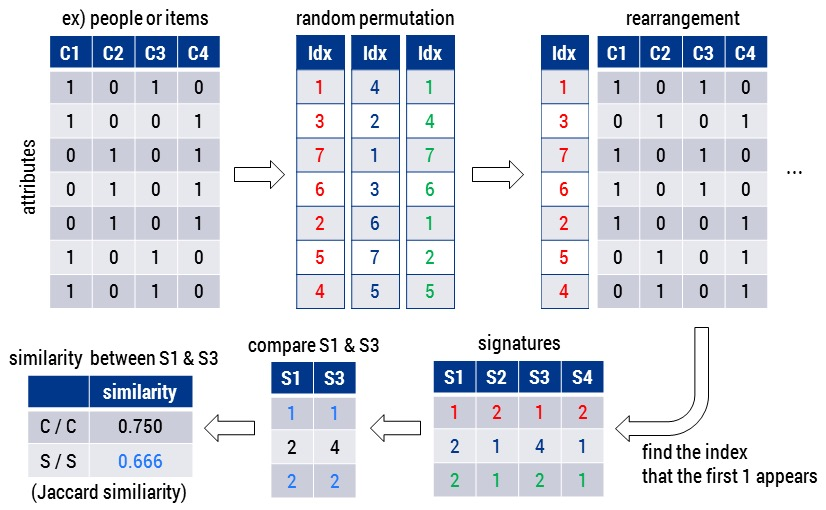  


#### 用随机排列估计Jaccard系数：
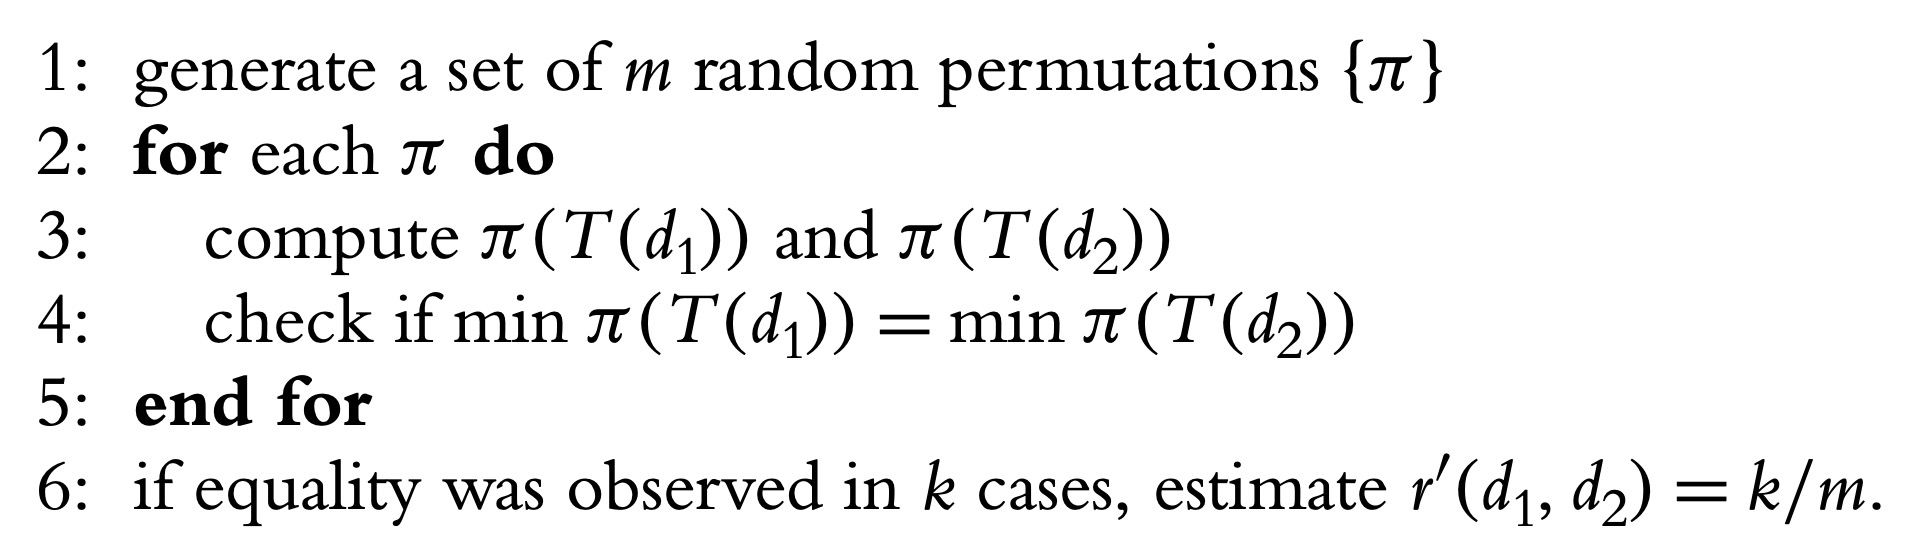  

#### 用随机排列实现快速相似文档搜索：
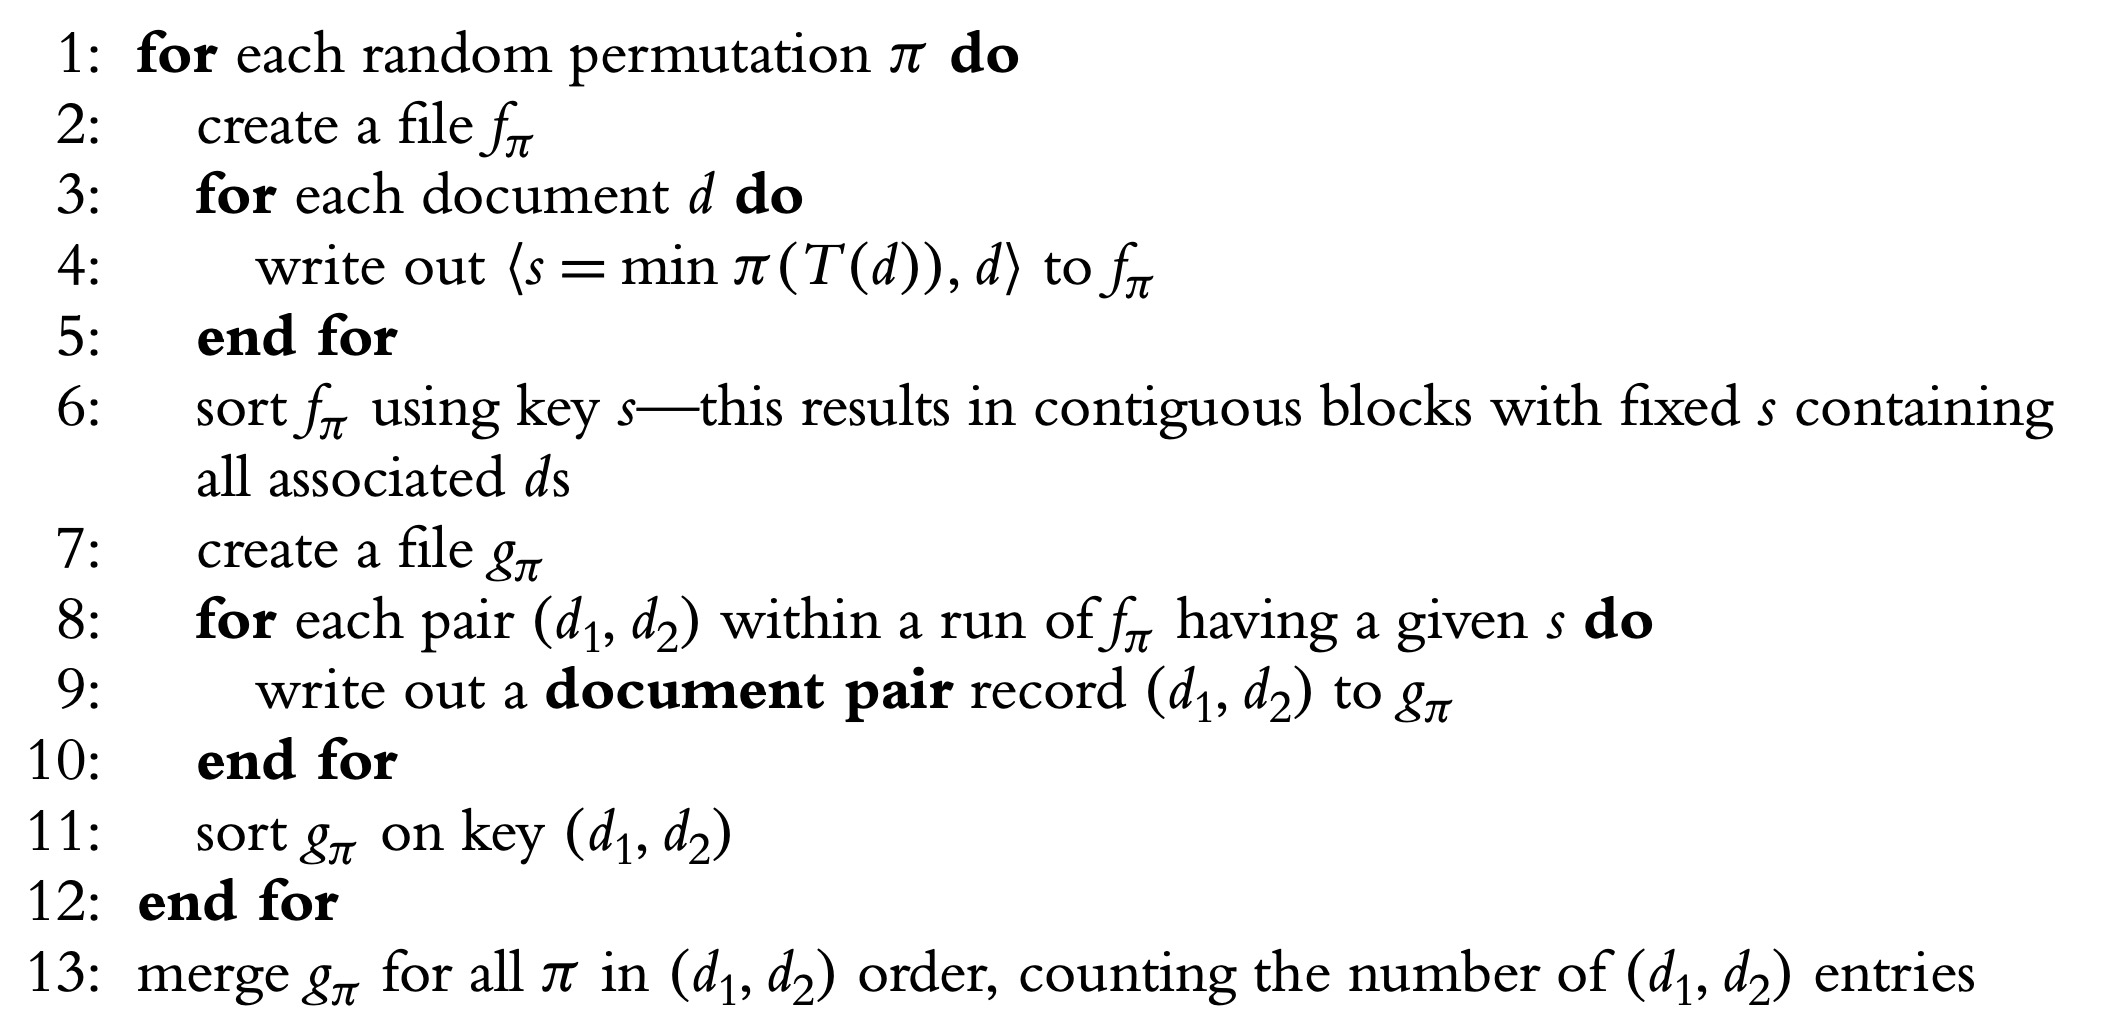

#### `Minhash算法`设计了一种`最小哈希函数`，将原始超高维的稀疏向量转化为低维的稠密向量，降低了计算的空间复杂度。同时，对转换后的稠密向量进行分段索引，缩小潜在相似文本范围，降低了计算的时间复杂度。
#### 最小哈希函数：对一个列向量按行进行随机排列，重排后第一个非零元素的行号就是最小哈希函数值。直观上来说，如果两个文本完全重复，那么不论如何重排，两个文本对应的最小哈希函数值都应该是一样的。

#### $P(Minhash(S_{1}) = Minhash(S_{2})) = Jaccard(S_{1},S_{2})$  

#### 计算潜在相似文本对的相似性：两个Minhash向量对应位置元素相等的比例，即为这两个文本的相似度$similarity = \frac{\sum_{n=1}^{N}{I(x_{n}==y_{n})}}{N}$ 
#### 当相似度大于指定阈值时，可认为两个文本为重复文本。

---  
#### `KShingle算法`和`Minhash算法`都需要生成一个庞大的Shingle词组库，当文本数量和文本长度很大时，计算这个词组库需要耗费巨大的时间和空间资源，且各文档的特征向量计算都依赖这个共同的词组库，因此计算特征向量的过程很难完全地并行化。`Simhash算法`仅基于文档中包含的词汇生成文档的特征向量，极大提高了计算效率。  
### Simhash算法  
#### simhash是google于2007年发布的一篇论文《Detecting Near-duplicates for web crawling》中提出的算法，初衷是用于解决亿万级别的网页去重任务   
#### simhash通常用于长文本，通过降维处理，将长文本压缩至几个关键词来代表一篇文章，然后再将这些关键词编码成一个固定长度的二进制字符串（一般为32位或是64位），这样即用一个固定长度的编码来表示一整篇文章，我们想要对比多篇文章，只需要对比这些固定长度的编码就可以了。  
#### 计算两个simhash的相似度通常使用`汉明距离(Hamming distance)`，就是计算两个编码相对位置不相同的个数，大于阈值则判定为不相似，小于等于阈值判定为相似

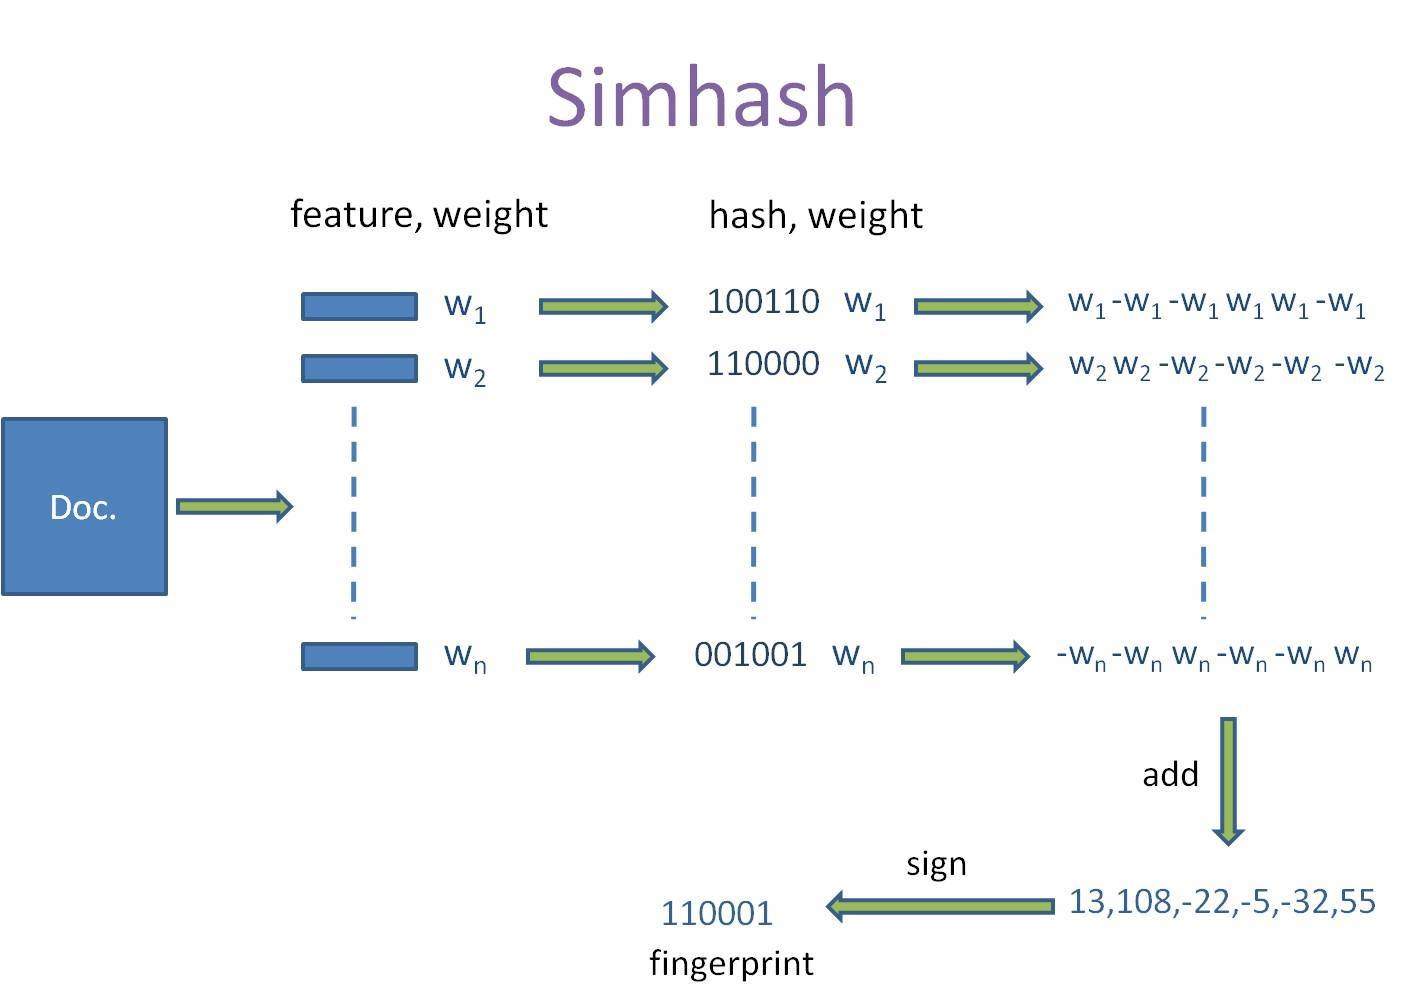

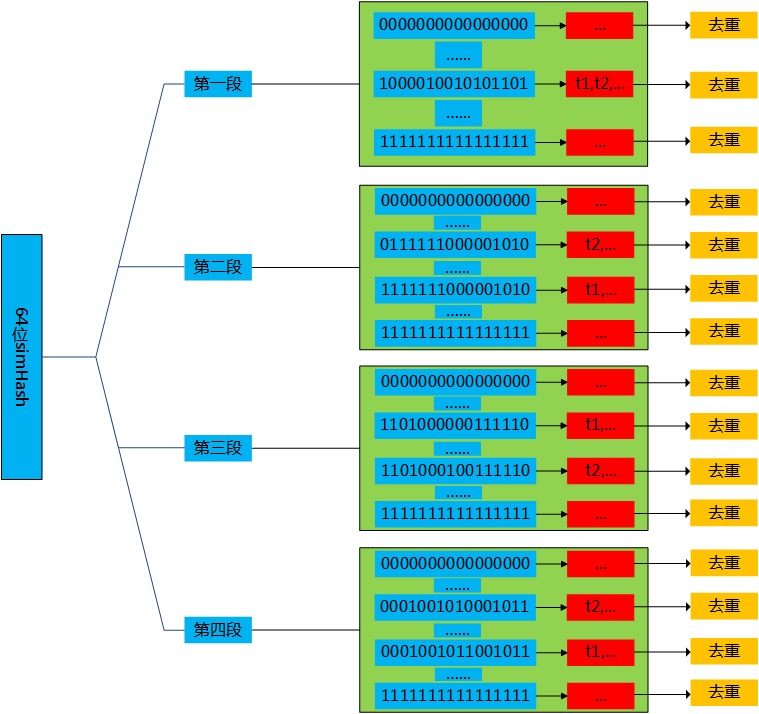